In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from google.cloud import bigquery

# Fetch Credentials - I created a key then literally dragged/dropped it to /content on google colab 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'local-receiver-341803-9e38525e7b40.json'

# Build BigQuery Client
client = bigquery.Client()

In [7]:
#Get the dataset

# Query for Position Histories from BigQuery - change limit after we know it works
QUERY = ('SELECT lastTrainReporting.positionHistoryList FROM `local-receiver-341803.testTrainEvents.train-event-data` LIMIT 50')
query_job = client.query(QUERY)

# Wait for job to finish
rows = query_job.result()

print("Num rows fetched: " + str(rows.total_rows))




Num rows fetched: 50


In [8]:
# Create the data frame - should have a timestamp in it

# Fetch each position time and milepost
positionMilepostTimesDataFrame = pd.DataFrame()

# For each returned record
for row in rows:
    # Scan each position history
    for positionHistory in row.get('positionHistoryList'):
        # The time that the train was at the specific milepost
        # Record the position time as seconds from epoch to use in regression model
        #positionTime = positionHistory.get('positionTime').timestamp()
        positionTime = positionHistory.get('positionTime')

        # How fast the train is traveling
        speedMPH = positionHistory.get('speedMPH')

        # Milepost location information
        milepostLocation = positionHistory.get('milepostLocation')
        # The unique identifier of the subdivision
        subdivisionId = milepostLocation.get('subdivisionId')
        # The unique identifier fo the milepost
        milepostNumber = milepostLocation.get('milepost').get('milepostNumber')

        # Construct new dataframe record
        dataframeRow = {'PositionTime': positionTime, 'SpeedMPH': speedMPH, 
                        'SubdivisionId': subdivisionId, 'MilepostNumber':milepostNumber}

        # Append the row to the data frame.
        positionMilepostTimesDataFrame = positionMilepostTimesDataFrame.append(dataframeRow, ignore_index = True)


#Return an item and drop from frame
date_time = pd.to_datetime(positionMilepostTimesDataFrame.pop("PositionTime"), format='%Y-%m-%d %H:%M:%S')

print("date time: \n" + str(date_time))

print("cols: " + str(positionMilepostTimesDataFrame.columns))

positionMilepostTimesDataFrame.head()

date time: 
0     2022-04-02 01:55:06+00:00
1     2022-04-02 01:54:08+00:00
2     2022-04-02 01:53:34+00:00
3     2022-04-02 01:52:49+00:00
4     2022-04-02 01:51:51+00:00
                 ...           
245   2022-04-15 04:00:43+00:00
246   2022-04-15 03:56:19+00:00
247   2022-04-15 03:55:43+00:00
248   2022-04-15 03:50:43+00:00
249   2022-04-15 03:45:43+00:00
Name: PositionTime, Length: 250, dtype: datetime64[ns, UTC]
cols: Index(['SpeedMPH', 'SubdivisionId', 'MilepostNumber'], dtype='object')


,SpeedMPH,SubdivisionId,MilepostNumber
0,-11.0,106.0,766.9261
1,-10.0,595.0,279.0362
2,-9.0,595.0,279.1244
3,-7.0,595.0,279.2209
4,-3.0,595.0,279.3100


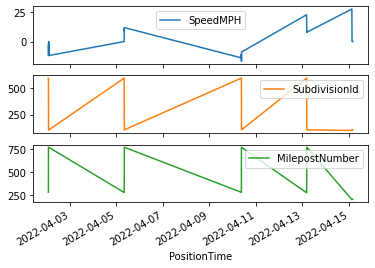

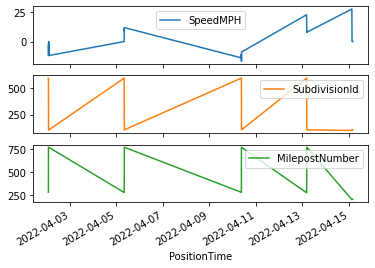

In [12]:
#Evolution of Features over time

plot_cols = ['SpeedMPH', 'SubdivisionId', 'MilepostNumber']
plot_features = positionMilepostTimesDataFrame[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = positionMilepostTimesDataFrame[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [13]:
# Inspect and clean up - look at statistics of dataset

positionMilepostTimesDataFrame.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SpeedMPH,250.0,0.096000,10.054809,-17.0000,-8.7500,0.00000,8.0000,28.0000
SubdivisionId,250.0,184.000000,179.738766,100.0000,106.0000,106.00000,106.0000,595.0000
MilepostNumber,250.0,507.498082,270.713400,200.3662,202.5352,764.86905,766.1568,766.9261


In [ ]:
# Data clean up - what data do we want to clean up now? For example, negative speeds??

# Leaving this section blank for now

Text(0.5, 1.0, 'Time of day signal thing')

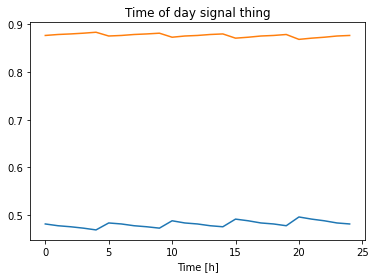

In [14]:
# Date time updates

timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

positionMilepostTimesDataFrame['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
positionMilepostTimesDataFrame['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
positionMilepostTimesDataFrame['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
positionMilepostTimesDataFrame['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(positionMilepostTimesDataFrame['Day sin'])[:25])
plt.plot(np.array(positionMilepostTimesDataFrame['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal thing')

In [ ]:
# Do we need to do a fast fourier transform? Maybe not.

In [15]:
# Finally get to some training things - split the data

column_indices = {name: i for i, name in enumerate(positionMilepostTimesDataFrame.columns)}

n = len(positionMilepostTimesDataFrame)

train_df = positionMilepostTimesDataFrame[0:int(n*0.7)]
val_df = positionMilepostTimesDataFrame[int(n*0.7):int(n*0.9)]
test_df = positionMilepostTimesDataFrame[int(n*0.9):]

num_features = positionMilepostTimesDataFrame.shape[1]

In [16]:
# Now we normalize the data - required before training a neural network. 

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std



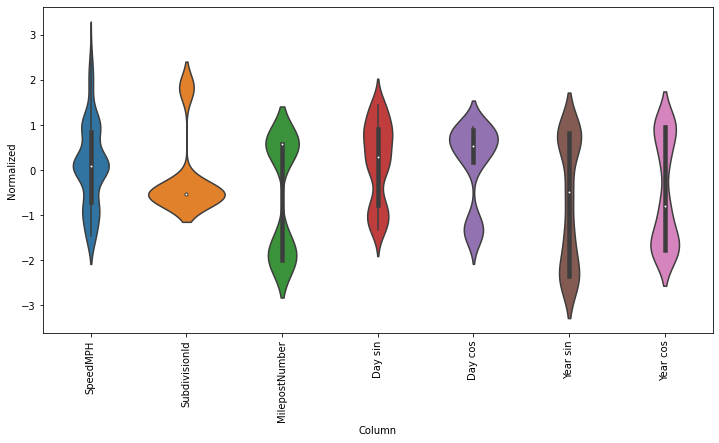

In [18]:
# View distribution of the features - look for obvious errors here

df_std = (positionMilepostTimesDataFrame - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))

ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(positionMilepostTimesDataFrame.keys(), rotation=90)

In [ ]:
# Data Windowing - done for reuse and for making prediction x hours into the future given y hours of history
# Main features: width of input and label windows, time offset between them, which features are used as inputs, labels or both